In [2]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import sys
import os
sys.path.append('../..')
from src.features.processing_func import mld
from src.utils.directories import get_parent_directory

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
parent_dir = get_parent_directory()

In [4]:
arctic_mix = os.path.join(parent_dir, "data/interim/arctic_mix.nc")
ABSO_nc = os.path.join(parent_dir, "data/interim/alberto_ds.nc")
mosaic_nc = os.path.join(parent_dir, "data/interim/mosaic_ds.nc")
nice_nc = os.path.join(parent_dir, "data/interim/nice_ds.nc")
HM_nc = os.path.join(parent_dir, "data/interim/ASBO-TEACOSI_ds.nc")

arctic_ds = xr.open_dataset(arctic_mix)
ABSO_ds = xr.open_dataset(ABSO_nc)
mosaic_ds = xr.open_dataset(mosaic_nc)
nice_ds = xr.open_dataset(nice_nc)
HM_ds = xr.open_dataset(HM_nc)

## MLD function
Also to be found in src/features/processing_func

In [128]:
import numpy as np
import xarray as xr

def mld(dataset, outfile, save_mld, threshold=0.01):
    """
    out = mld(dataset, outfile, save_mld, threshold)

    Reads:
        dataset    :: xarray dataset containing rho, drhodz, and d2rhodz2 variables
        outfile    :: output file to save the snapshot of the computed MLD
        save_mld   :: if True, the computed MLD will be saved in the output file
        threshold  :: threshold value for the potential density criterion (default: 0.01)

    Returns:
        MLDI, MLDJ  :: xarray DataArrays representing the MLD indices and values
    """
    dataset["rho"] = gsw.rho(dataset["S"], dataset["T"], 0)
    dataset['drhodz'] = dataset.rho.differentiate('depth')
    dataset['d2rhodz2'] = dataset.drhodz.differentiate('depth')

    # Extract variables from the dataset
    rho = dataset["rho"]
    drhodz = dataset["drhodz"]
    d2rhodz2 = dataset["d2rhodz2"]

    # Extract dimensions from the dataset
    depth_size, profile_size = rho.shape

    MLDI = np.ones((profile_size,)) * np.nan
    MLDJ = np.ones((profile_size,)) * np.nan

    for profile_num in range(profile_size):
    #for profile_num in range(10):
        tmp = drhodz[:, profile_num]
        tmp2 = d2rhodz2[:, profile_num]

        if np.isnan(tmp).all():
            continue

        # Find the index of minimum stratification
        I = np.nanargmin(tmp)
        MLDI[profile_num] = I

        if I > 2:
            # Check for non-NaN values in the slice
            valid_slice = tmp2[:I][~np.isnan(tmp2[:I])]
            if len(valid_slice) > 0:
                J = np.nanargmax(valid_slice)
                I = min(I, J)

        if tmp2[I] < 0. and (I > 4 and I == J):
            MLDJ[profile_num] = 0
        else:
            # Use threshold-based approach if no clear minimum stratification
            if np.nanmin(tmp) > threshold:
                # Find the index where drhodz first exceeds the threshold
                indices_above_threshold = np.where(tmp > threshold)[0]
                if len(indices_above_threshold) > 0:
                    I = indices_above_threshold[0]

            MLDJ[profile_num] = I

    if save_mld:
        # Save the MLD
        MLD_dataset = xr.Dataset({"MLDI": (("profile",), MLDI), "MLDJ": (("profile",), MLDJ)})
        MLD_dataset.to_netcdf(outfile)

    #MLDI = xr.DataArray(MLDI, dims=("profile",), coords={"profile": range(profile_size)})
    #MLDJ = xr.DataArray(MLDJ, dims=("profile",), coords={"profile": range(profile_size)})
    
    #dataset["MLDI"] = MLDI
    #dataset["MLDJ"] = MLDJ
    
    
    MLD_dataset = xr.Dataset({"MLDI": (("profile",), MLDI), "MLDJ": (("profile",), MLDJ)})
    
    # Combine MLD_dataset with the original dataset
    dataset.update(MLD_dataset)
    return dataset


In [6]:
nice_mld = mld(nice_ds)

## Use MLDI of MLDJ?

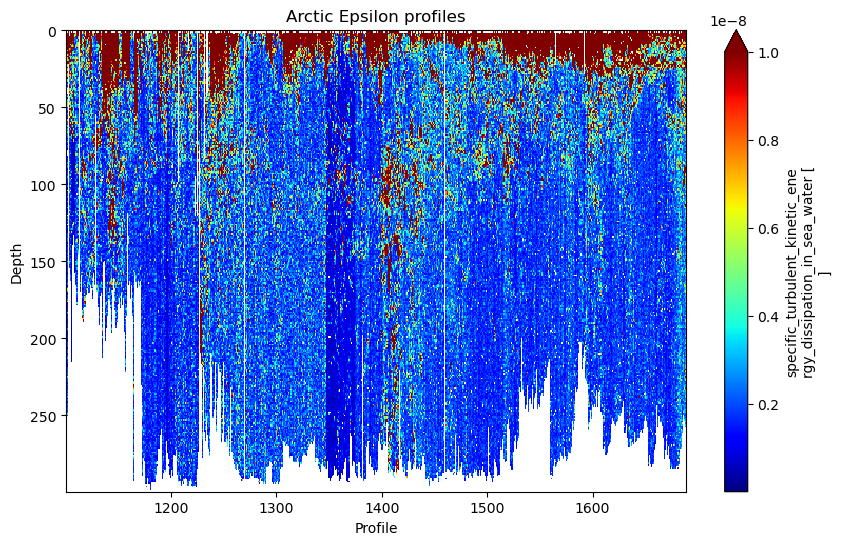

In [5]:
# Plot the MLD data
plt.figure(figsize=(10, 6))
nice_ds.eps.plot(cmap='jet', vmin=1e-11, vmax=1e-8)  # Adjust the vmin and vmax values as needed

# Add title and labels
plt.title("Arctic Epsilon profiles")
plt.xlabel("Profile")
plt.ylabel("Depth")
plt.gca().invert_yaxis()

# Add colorbar
# cbar = plt.colorbar()
# cbar.set_label("Mixed Layer Depth (m)")  # Adjust the colorbar label as needed

# Save the plot
# plt.savefig("arctic_mld.eps")

# Show the plot
plt.show()

Visually, MLDJ, based on the second derivative, looks better

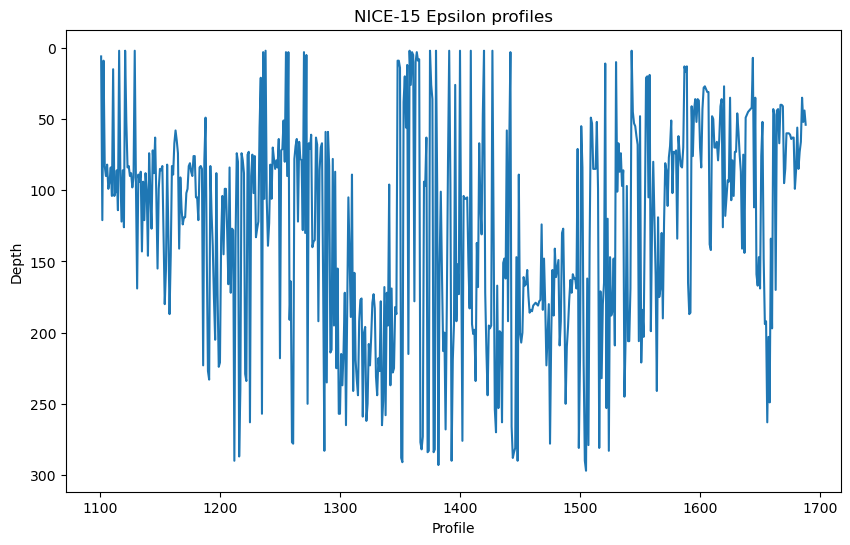

In [12]:
# Plot the MLD data
plt.figure(figsize=(10, 6))
nice_mld.MLDI.plot()

# Add title and labels
plt.title("NICE-15 Epsilon profiles")
plt.xlabel("Profile")
plt.ylabel("Depth")
plt.gca().invert_yaxis()

# Show the plot
plt.show()

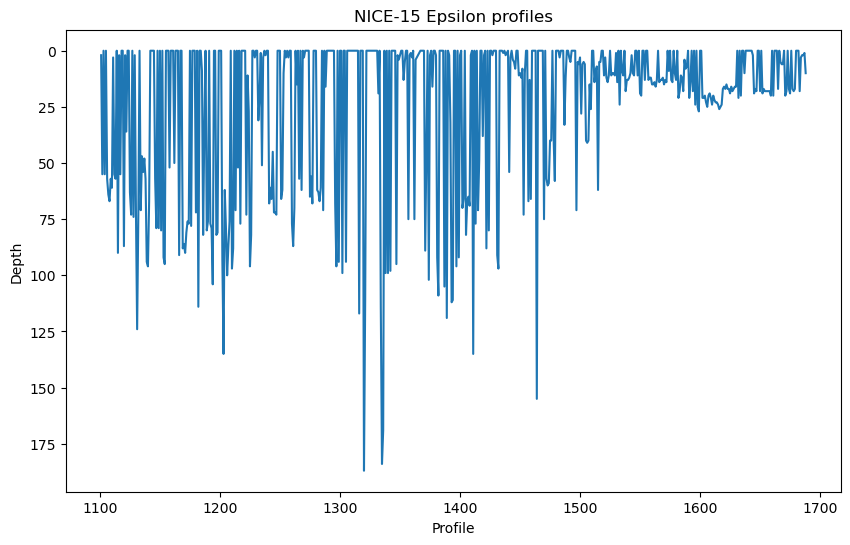

In [13]:
# Plot the MLD data
plt.figure(figsize=(10, 6))
nice_mld.MLDJ.plot()

# Add title and labels
plt.title("NICE-15 Epsilon profiles")
plt.xlabel("Profile")
plt.ylabel("Depth")
plt.gca().invert_yaxis()

# Show the plot

## Statistical analysis

In [5]:
import scipy.stats as stats

def statistical_MLD(dataset, plot = False):
    # Extract MLDI and MLDJ values from the dataset
    MLDI_values = dataset["MLDI"].values
    MLDJ_values = dataset["MLDJ"].values

    # Create a DataFrame for the MLD values
    data = pd.DataFrame({"MLDI": MLDI_values, "MLDJ": MLDJ_values})

    # Perform statistical analysis
    mean_MLDI = np.nanmean(MLDI_values)
    mean_MLDJ = np.nanmean(MLDJ_values)
    median_MLDI = np.nanmedian(MLDI_values)
    median_MLDJ = np.nanmedian(MLDJ_values)
    std_MLDI = np.nanstd(MLDI_values)
    std_MLDJ = np.nanstd(MLDJ_values)
    ttest_result = stats.ttest_ind(MLDI_values, MLDJ_values, nan_policy="omit")

    # Print the statistical results
    print("Statistical Analysis Results:")
    print("----------------------------------------")
    print("Mean MLDI: {:.2f}".format(mean_MLDI))
    print("Mean MLDJ: {:.2f}".format(mean_MLDJ))
    print("Median MLDI: {:.2f}".format(median_MLDI))
    print("Median MLDJ: {:.2f}".format(median_MLDJ))
    print("Standard Deviation MLDI: {:.2f}".format(std_MLDI))
    print("Standard Deviation MLDJ: {:.2f}".format(std_MLDJ))
    print("T-Test p-value: {:.4f}".format(ttest_result.pvalue))
    print("----------------------------------------")

    if plot == True:
        # Plot histogram
        plt.figure(figsize=(10, 6))
        plt.hist(MLDI_values, bins=30, alpha=0.5, label='MLDI')
        plt.hist(MLDJ_values, bins=30, alpha=0.5, label='MLDJ')
        plt.xlabel('MLD Value')
        plt.ylabel('Frequency')
        plt.title('Distribution of MLDI and MLDJ')
        plt.legend()

        # Plot boxplot
        plt.figure(figsize=(8, 6))
        plt.boxplot([MLDI_values, MLDJ_values], labels=['MLDI', 'MLDJ'])
        plt.ylabel('MLD Value')
        plt.title('Boxplot of MLDI and MLDJ')
        plt.show()


NICE is north of Svalbard, similar to boundary of Eurasian basin and Barents Sea. Cruise was conducted in the spring and summer. According to Ferriz et al, 2015, MLD should then be around 20m, which is consistent with mean MLDJ.

Statistical Analysis Results:
----------------------------------------
Mean MLDI: 127.30
Mean MLDJ: 24.38
Median MLDI: 111.00
Median MLDJ: 6.00
Standard Deviation MLDI: 75.46
Standard Deviation MLDJ: 34.95
T-Test p-value: 0.0000
----------------------------------------


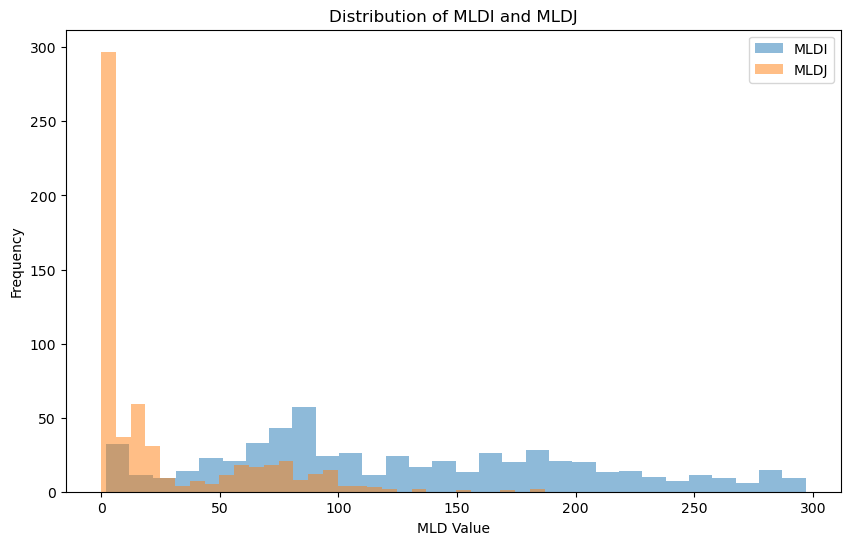

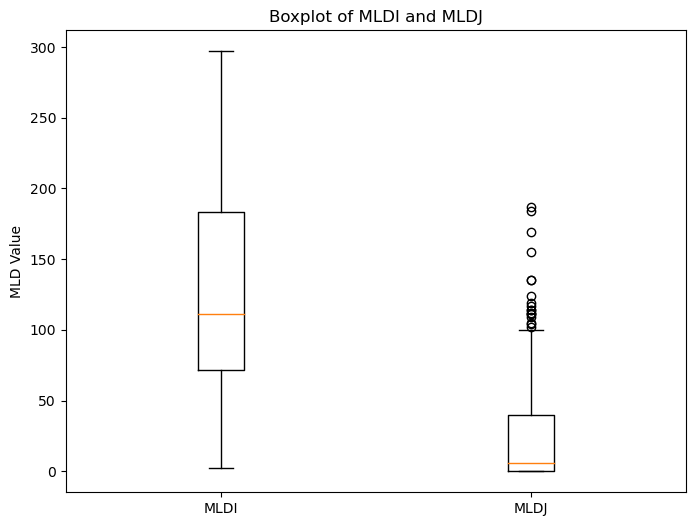

In [7]:
statistical_MLD(nice_mld, True)

## See if same for other profiles too

In [9]:
arctic_mld = mld(arctic_ds)

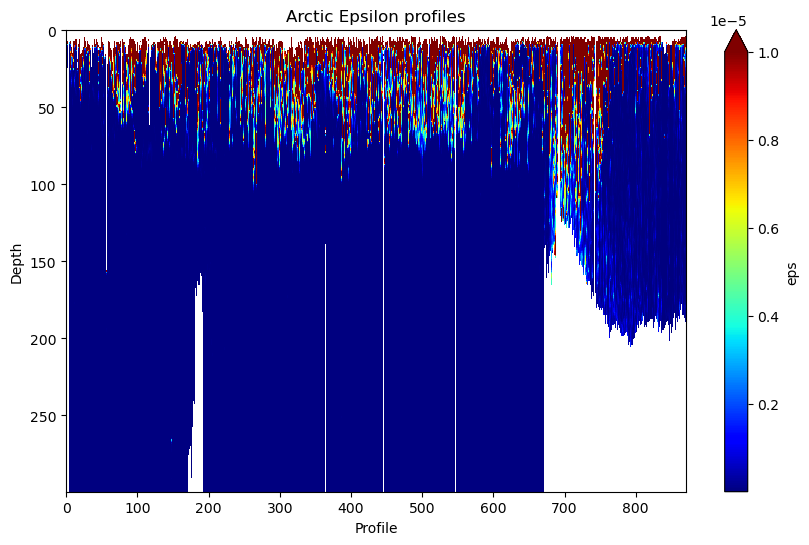

In [10]:
# Plot the MLD data
plt.figure(figsize=(10, 6))
arctic_mld.eps.plot(cmap='jet', vmin=1e-10, vmax=1e-5)  # Adjust the vmin and vmax values as needed

# Add title and labels
plt.title("Arctic Epsilon profiles")
plt.xlabel("Profile")
plt.ylabel("Depth")
plt.gca().invert_yaxis()

# Add colorbar
# cbar = plt.colorbar()
# cbar.set_label("Mixed Layer Depth (m)")  # Adjust the colorbar label as needed

# Save the plot
# plt.savefig("arctic_mld.eps")

# Show the plot
plt.show()

Ferriz 2015: ArcticMix. Above Alaska, near CS (chukchi sea). research in beginning of Autum, so take MLD of summer, around 12m from the paper -> MLDJ is closer

In [22]:
statistical_MLD(arctic_mld)

Statistical Analysis Results:
----------------------------------------
Mean MLDI: 137.89
Mean MLDJ: 32.79
Median MLDI: 94.00
Median MLDJ: 5.00
Standard Deviation MLDI: 105.75
Standard Deviation MLDJ: 53.02
T-Test p-value: 0.0000
----------------------------------------


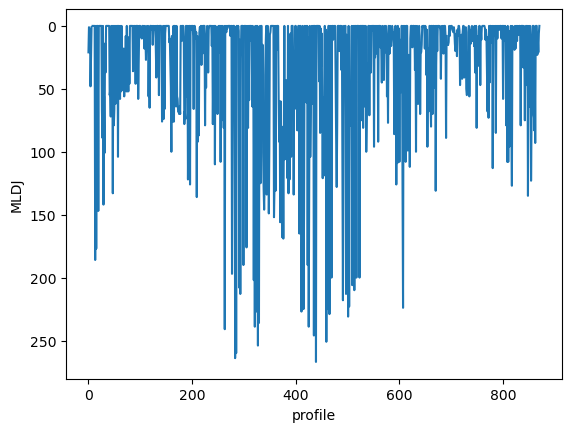

In [25]:
arctic_mld.MLDJ.plot()
plt.gca().invert_yaxis()

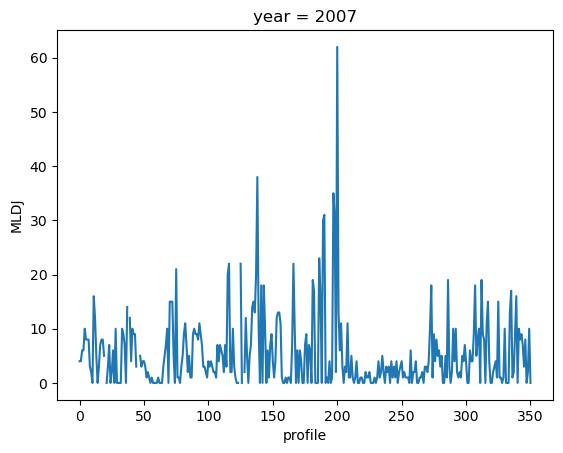

In [26]:
ABSO_mld = mld(ABSO_ds)
ABSO_mld.MLDJ.plot()

From Ferriz (2015) paper: sampling continental shelves mostly in summer, so MLD around 9m i.e. in Canada basin. However, MLDI in this case is not necessarily worse.

In [28]:
statistical_MLD(ABSO_mld)

Statistical Analysis Results:
----------------------------------------
Mean MLDI: 31.25
Mean MLDJ: 5.33
Median MLDI: 26.00
Median MLDJ: 3.00
Standard Deviation MLDI: 18.88
Standard Deviation MLDJ: 6.91
T-Test p-value: 0.0000
----------------------------------------


Ferriz (2015): HM cruise was in early autumn and near the svalbard, so MLD around 20m. Would say MLDI is a better fit in this case.

In [30]:
HM_mld = mld(HM_ds)
statistical_MLD(HM_mld)

Statistical Analysis Results:
----------------------------------------
Mean MLDI: 31.25
Mean MLDJ: 5.33
Median MLDI: 26.00
Median MLDJ: 3.00
Standard Deviation MLDI: 18.88
Standard Deviation MLDJ: 6.91
T-Test p-value: 0.0000
----------------------------------------


Ferriz (2015): mosaic cruise, sampling Makarov basin and the Eurasian basin. In winter, MLD around 50-70m (from paper) and in summer around 20m. Looking at the distributions of MLD, sample it a bit better?

Statistical Analysis Results:
----------------------------------------
Mean MLDI: 162.00
Mean MLDJ: 15.11
Median MLDI: 207.00
Median MLDJ: 5.00
Standard Deviation MLDI: 133.81
Standard Deviation MLDJ: 21.49
T-Test p-value: 0.0000
----------------------------------------


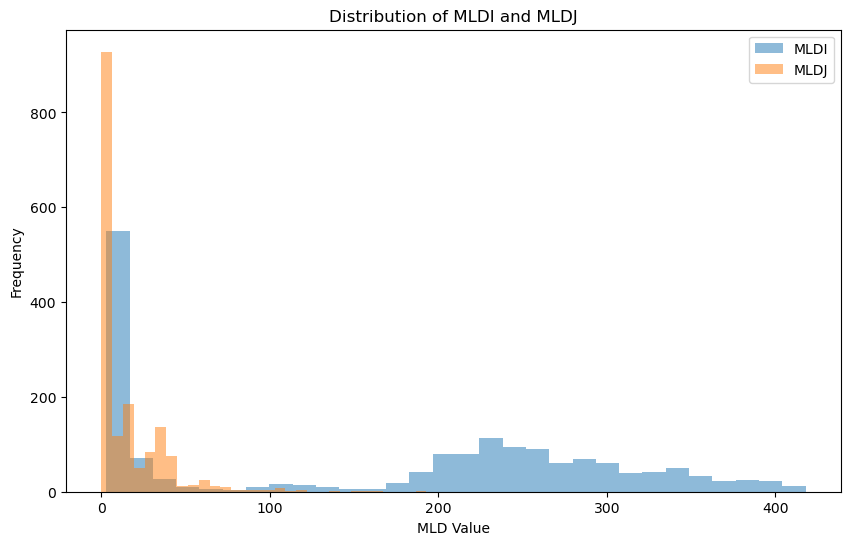

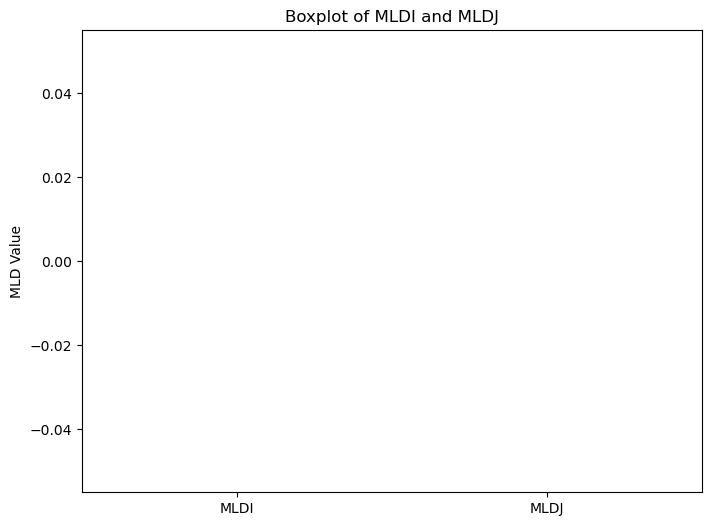

In [7]:
mosaic_mld = mld(mosaic_ds)
statistical_MLD(mosaic_mld, True)